In [1]:
%autosave 0
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

import xgboost

from alys import regression as ALYR
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


# Contexte

In [2]:
mod_full = False # Active le fichier de scrap si on passe sur True = le fichier de scrap + celui traité par Aro sur gouv
look_for_opti = False # Active gridsearch

In [3]:
if mod_full:
    df = pd.read_csv('Base_Files/house_full.csv', index_col =0)
else :    
    df = pd.read_csv('Base_Files/house_ligth.csv', index_col =0)

# Visualisation des données

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3505 entries, 0 to 1817
Data columns (total 7 columns):
id              3505 non-null int64
type_de_bien    3505 non-null object
année           1687 non-null float64
nb_de_pieces    3505 non-null int64
surface         3505 non-null int64
ville           3505 non-null object
prix            3505 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 219.1+ KB


In [5]:
def null_values(df):
    
    sum_null = df.isnull().sum()
    total = df.isnull().count()
    percent_nullvalues = 100* sum_null / total 
    df_null = pd.DataFrame()
    df_null['Total'] = total
    df_null['Null_Count'] = sum_null
    df_null['Percent'] = round(percent_nullvalues,2)
    df_null = df_null.sort_values(by='Null_Count',ascending = False)
    df_null = df_null[df_null.Null_Count > 0]
    
    return(df_null)

null_values(df)

,Total,Null_Count,Percent
année,3505,1818,51.87


In [6]:
df = df.drop(['id','année'], axis=1)

In [7]:
df['ville'] = df['ville'].str.strip() #Correction du premier charactère == " ".

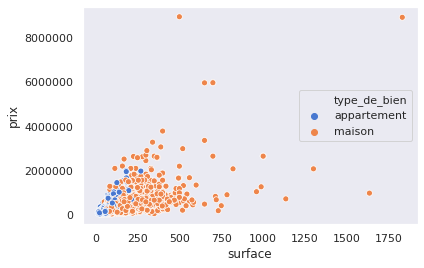

In [8]:
sns.set(style="dark", palette="muted", font='DejaVu Sans', font_scale=1, color_codes=True)
sns.scatterplot(x="surface", y="prix", hue="type_de_bien", data=df)

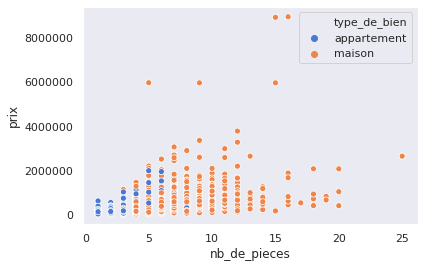

In [9]:
sns.set(style="dark", palette="muted", font='DejaVu Sans', font_scale=1, color_codes=True)
sns.scatterplot(x="nb_de_pieces", y="prix", hue="type_de_bien", data=df)

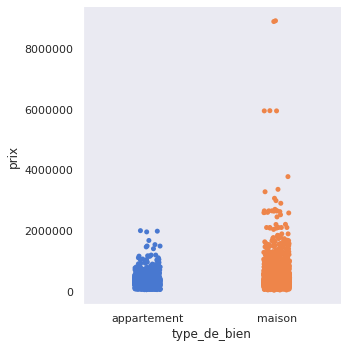

In [10]:
sns.catplot(x='type_de_bien',y='prix',data=df ,hue='type_de_bien')

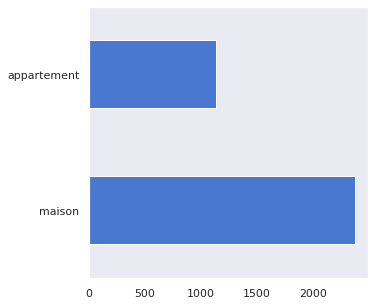

In [11]:
df['type_de_bien'].value_counts().head(2).plot(kind='barh', figsize=(5,5))

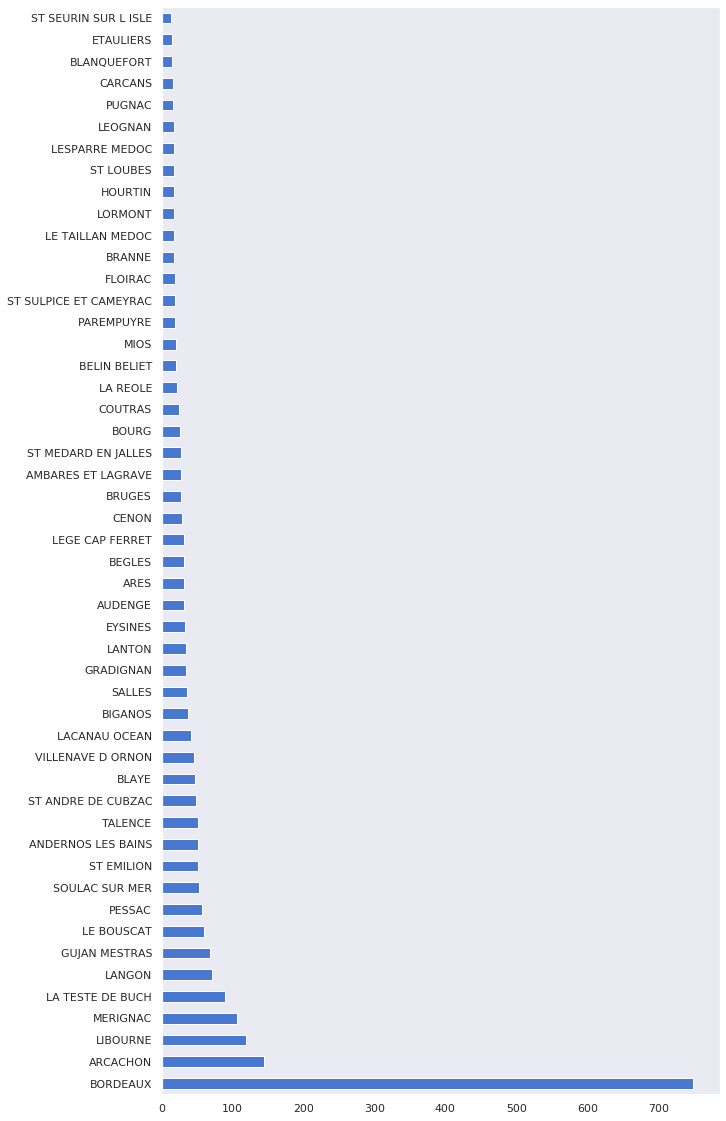

In [12]:
df['ville'].value_counts().head(50).plot(kind='barh', figsize=(10,20))

In [13]:
# x = df.groupby('ville').agg(['count'])

# count=0
# vill_mal_rep = []

# for ele in x['prix', 'count'] :
#     if ele < 3 :
#         vill_mal_rep.append(x.index[count])
#     count += 1 
    
# # Liste des villes représentées 1 ou 2 fois dans le df     
# vill_mal_rep

# Suppression des outliers

A l'aide des visualisations, je fais le lien avec les index a drop

In [14]:
df.sort_values("prix", axis = 0, ascending = False).head(10)

,type_de_bien,nb_de_pieces,surface,ville,prix
1155,maison,16,500,BORDEAUX,8925000
1480,maison,15,1830,BORDEAUX,8900000
1337,maison,5,700,ARCACHON,5956500
1215,maison,9,700,ARCACHON,5950000
383,maison,15,650,ARCACHON,5950000
1598,maison,12,400,BORDEAUX,3780000
892,maison,9,650,BORDEAUX,3360000
344,maison,12,340,ARCACHON,3280000
1472,maison,7,389,ARCACHON,3065000
74,maison,11,520,LE BOUSCAT,2987000


In [15]:
df.sort_values("surface", axis = 0, ascending = False).head(10)

,type_de_bien,nb_de_pieces,surface,ville,prix
1480,maison,15,1830,BORDEAUX,8900000
269,maison,8,1634,SALLES,987000
1590,maison,20,1300,CASSEUIL,2080000
1378,maison,5,1135,LACANAU OCEAN,728000
1626,maison,25,1000,BORDEAUX,2650000
404,maison,25,1000,BORDEAUX,2650000
403,maison,25,1000,BLAYE,2650000
1319,maison,14,988,ARVEYRES,1272000
636,maison,20,960,BORDEAUX,1050000
198,maison,18,820,BORDEAUX,2080000


In [16]:
df.sort_values("nb_de_pieces", axis = 0, ascending = False).head(10)

,type_de_bien,nb_de_pieces,surface,ville,prix
404,maison,25,1000,BORDEAUX,2650000
403,maison,25,1000,BLAYE,2650000
1626,maison,25,1000,BORDEAUX,2650000
636,maison,20,960,BORDEAUX,1050000
518,maison,20,540,PUGNAC,420000
1590,maison,20,1300,CASSEUIL,2080000
517,maison,20,540,ST CHRISTOLY DE BLAYE,420000
1288,maison,19,575,LIBOURNE,680000
712,maison,19,715,BORDEAUX,840000
711,maison,18,400,LIBOURNE,945000


In [17]:
df.sort_values("prix", axis = 0, ascending = True).head(10)

,type_de_bien,nb_de_pieces,surface,ville,prix
766,maison,3,40,RAUZAN,28500
126,maison,3,68,RAUZAN,38500
1624,maison,2,41,VILLENEUVE,40000
258,maison,3,87,ST YZANS DE MEDOC,40000
230,maison,2,30,AUROS,45000
669,appartement,2,36,BLAYE,48000
52,appartement,2,50,CARTELEGUE,48000
1583,maison,4,97,STE FOY LA GRANDE,49000
1801,appartement,1,25,GIRONDE SUR DROPT,50000
1802,appartement,1,25,GIRONDE SUR DROPT,50000


In [18]:
# -- Outliers général -- 1155, 1337,1215,269,518,517 
df = df.drop([df.index[1155] , df.index[1337], df.index[1215],
              df.index[269],df.index[518] ,df.index[517]])

In [19]:
df.shape

(3493, 5)

# Preprocessing, Split et création de Pipeline

In [20]:
df['PriceLog'] = np.log(df.prix)

In [21]:
corr = df.corr().abs()
corr.prix[corr.prix >= 0].sort_values(ascending=False)

prix            1.000000
PriceLog        0.819907
surface         0.598269
nb_de_pieces    0.503994
Name: prix, dtype: float64

In [22]:
y_full = df['PriceLog'].values

x_full = df.drop(['prix','PriceLog'], axis=1)
x_full.shape,y_full.shape

((3493, 4), (3493,))

In [23]:
categoricals = ['type_de_bien', 'ville']

In [24]:
categorical_pipe = Pipeline([
    ('oe', OneHotEncoder(handle_unknown="ignore"))
])

In [25]:
poly = ['nb_de_pieces', 'surface']

In [26]:
poly_pipe = Pipeline([
    ("poly", PolynomialFeatures(2))
])

In [27]:
scale_pipe = Pipeline([
    ('scaler', StandardScaler())
])

In [28]:
preprocess_pipe = ColumnTransformer([
    ("enc", categorical_pipe, categoricals),
    ("sca", scale_pipe, poly),
    ("pol", poly_pipe , poly),
])

In [29]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.5, subsample=0.7,
                             learning_rate=0.05, max_depth=5, 
                             min_child_weight=1.8, n_estimators=1000,
                             reg_alpha=0.1, reg_lambda=0.3, gamma=0.01, 
                             silent=1, random_state =7, nthread = -1)

In [30]:
seed = 60
np.random.seed(seed)

In [31]:
x_train, x_val, y_train, y_val = train_test_split(x_full,y_full , test_size=0.1, random_state=seed)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((3143, 4), (350, 4), (3143,), (350,))

In [32]:
model = Pipeline([
    ('pre', preprocess_pipe),
    ('reg', xgb)
])

# Entrainement du modèle

In [33]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pre', 'reg', 'pre__n_jobs', 'pre__remainder', 'pre__sparse_threshold', 'pre__transformer_weights', 'pre__transformers', 'pre__verbose', 'pre__enc', 'pre__sca', 'pre__pol', 'pre__enc__memory', 'pre__enc__steps', 'pre__enc__verbose', 'pre__enc__oe', 'pre__enc__oe__categories', 'pre__enc__oe__drop', 'pre__enc__oe__dtype', 'pre__enc__oe__handle_unknown', 'pre__enc__oe__sparse', 'pre__sca__memory', 'pre__sca__steps', 'pre__sca__verbose', 'pre__sca__scaler', 'pre__sca__scaler__copy', 'pre__sca__scaler__with_mean', 'pre__sca__scaler__with_std', 'pre__pol__memory', 'pre__pol__steps', 'pre__pol__verbose', 'pre__pol__poly', 'pre__pol__poly__degree', 'pre__pol__poly__include_bias', 'pre__pol__poly__interaction_only', 'pre__pol__poly__order', 'reg__base_score', 'reg__booster', 'reg__colsample_bylevel', 'reg__colsample_bynode', 'reg__colsample_bytree', 'reg__gamma', 'reg__importance_type', 'reg__learning_rate', 'reg__max_delta_step', 'reg__max_depth', 'reg_

In [34]:
if look_for_opti : 
    param_grid = [{
        'reg__n_estimators': [800,900,1000,1200],'reg__max_depth': [4,5,6,7]
    }]

    my_learn = model
    grid_search = GridSearchCV(my_learn,param_grid, cv=5, scoring ='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(x_train,y_train)

if look_for_opti : 
    grid_search.best_params_

In [35]:
model.fit(x_train,y_train);

# Evaluation du modèle avec le fichier de validation

In [36]:
y_valid_pred = model.predict(x_val)

RMSE :  143957.6701
MAE :  90220.8373


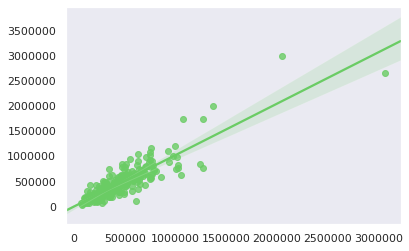

In [37]:
xgb_pred_ref = np.exp(y_valid_pred)

y_val_rescale = y_val.reshape(y_val.shape[0])
y_val_rescale = np.exp(y_val_rescale)

RMSE = np.sqrt(MSE(xgb_pred_ref, y_val_rescale))
print('RMSE : ', RMSE.round(4))

score = MAE(xgb_pred_ref, y_val_rescale)
print('MAE : ', round(score,4))

sns.regplot(xgb_pred_ref, y_val_rescale, color="g")

In [38]:
visu = pd.DataFrame()
visu["val_price"] = y_val_rescale
visu["Prediction"] = xgb_pred_ref

ALYR.regr(visu)
ALYR.posneg(visu)

######### saisir Prediction puis val_price ###############

nom colonne prediction : Prediction
nom colonne output : val_price
MAPE =  26.02
On a 176 erreurs positive, 174 erreurs negative, 0 prediction parfaite


,val_price,Prediction,pourcerror,errorabs,mape,RMSE,positive erreur,negatif erreur,prediction parfaite
0,313000.0,292478.187500,-0.065565,0.07,26.02,143957.67013,176.0,174.0,0.0
1,254000.0,238219.109375,-0.062129,0.06,NaN,NaN,NaN,NaN,NaN
2,242000.0,489031.687500,1.020792,1.02,NaN,NaN,NaN,NaN,NaN
3,840000.0,510569.000000,-0.392180,0.39,NaN,NaN,NaN,NaN,NaN
4,318000.0,287119.750000,-0.097108,0.10,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
345,335000.0,294798.843750,-0.120003,0.12,NaN,NaN,NaN,NaN,NaN
346,75000.0,87641.601562,0.168555,0.17,NaN,NaN,NaN,NaN,NaN
347,389200.0,402215.812500,0.033442,0.03,NaN,NaN,NaN,NaN,NaN
348,213000.0,224030.843750,0.051788,0.05,NaN,NaN,NaN,NaN,NaN


In [39]:
visu.sort_values("errorabs", axis = 0, ascending = False).head(20)

,val_price,Prediction,pourcerror,errorabs,mape,RMSE,positive erreur,negatif erreur,prediction parfaite
76,99000.0,605878.687500,5.119987,5.12,NaN,NaN,NaN,NaN,NaN
164,76000.0,277630.468750,2.653032,2.65,NaN,NaN,NaN,NaN,NaN
139,110000.0,297468.781250,1.704262,1.70,NaN,NaN,NaN,NaN,NaN
172,86500.0,226121.531250,1.614122,1.61,NaN,NaN,NaN,NaN,NaN
144,60000.0,144529.375000,1.408823,1.41,NaN,NaN,NaN,NaN,NaN
22,123000.0,265314.031250,1.157025,1.16,NaN,NaN,NaN,NaN,NaN
176,90000.0,192659.781250,1.140664,1.14,NaN,NaN,NaN,NaN,NaN
184,60000.0,128215.765625,1.136929,1.14,NaN,NaN,NaN,NaN,NaN
187,108300.0,231386.734375,1.136535,1.14,NaN,NaN,NaN,NaN,NaN
48,38500.0,81126.835938,1.107191,1.11,NaN,NaN,NaN,NaN,NaN


In [40]:
ALYR.seuil_vs_error(visu)

######## Choisir un seuil en float entre 0.0 et 1 ######################

valeur du seuil :0.2
il y'a 212 erreurs inférieurs à 0.2, il y'a 138 erreurs supérieurs à 0.2
erreur sous seuil = 60.5714%


60.5714

In [41]:
ALYR.seuil_vs_error(visu)

######## Choisir un seuil en float entre 0.0 et 1 ######################

valeur du seuil :0.1
il y'a 113 erreurs inférieurs à 0.1, il y'a 237 erreurs supérieurs à 0.1
erreur sous seuil = 32.2857%


32.2857

In [42]:
######## Dump du modèle, pensez a changer le numéro de version ######################

# dump(model, 'model_xgb_v2.joblib')

# Simulation en Production

In [43]:
def singlePrediction():
    k1 = str(input("Type de bien : maison ou appartement : "))
    k1 = k1.lower()
    k2 = int(input("Nombre de pièces dans le logement : "))
    
    k3 = int(input("Combien de métres carrés : "))
    k4 = str(input("Dans quelle ville : "))
    k4= k4.upper()
    
    x = pd.DataFrame()
    x.loc[0,"type_de_bien"] = f"{k1}"
    x.loc[0,"nb_de_pieces"] = f"{k2}"
    x.loc[0,"surface"] = f"{k3}"
    x.loc[0,"ville"] = f"{k4}"
    print("-------------")
    sing_pred = model.predict(x)
    sing_pred = np.exp(sing_pred)
    print("-------------")
    print("Prix estimé ",int(sing_pred), "€")
    

In [44]:
singlePrediction()

Type de bien : maison ou appartement : appartement
Nombre de pièces dans le logement : 2
Combien de métres carrés : 35
Dans quelle ville : Bordeaux
-------------
-------------
Prix estimé  167013 €


In [45]:
singlePrediction()

Type de bien : maison ou appartement : maison
Nombre de pièces dans le logement : 5
Combien de métres carrés : 100
Dans quelle ville : port ste foy et ponchapt
-------------
-------------
Prix estimé  259196 €


# Verification de la gestion des erreurs d'input utilisateur

In [46]:
singlePrediction()

Type de bien : maison ou appartement : je ne sais pas
Nombre de pièces dans le logement : 14
Combien de métres carrés : 1000
Dans quelle ville : peut importe
-------------
-------------
Prix estimé  1660016 €


# Evolution du Score du modèle en production

# --V1--

# --V2--